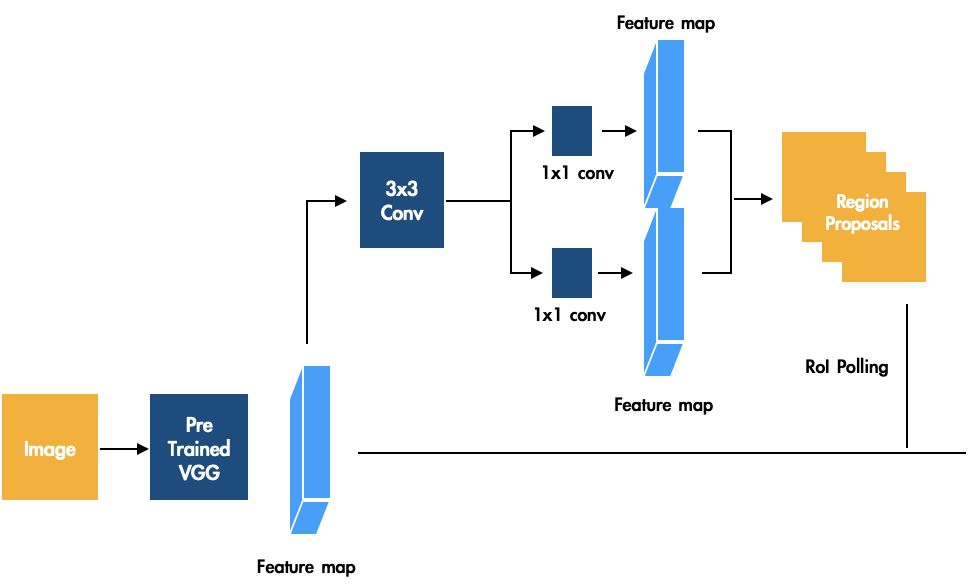

###Image :
At the part of 'Extract resized ground truth box' I resized the image and ground truth box for the purpose of matching with VGG16

###VGG ~ Feature Map~ 3x3 Conv : 
feature_extractor = layers.Conv2D(filters=512, kernel_size=(3,3), padding="valid", activation="relu")(x)

###1x1 Conv - Classification layer:
obj_conv = layers.Conv2D(filters=18, kernel_size=(1,1), padding="valid", activation=None)(feature_extractor)


class_conv_reshape = tf.reshape(obj_conv, (-1, 26x26x9, 2))


###1x1 Conv - Box regression layer:
bb_conv = layers.Conv2D(filters=36, kernel_size=(1,1), padding="valid", activation=None)(feature_extractor)

anchor_conv_reshape = tf.reshape(bb_conv, (-1, 26x26x9, 4))

###Anchor Box Gernerating processes are showed below with examples
###Since the shortage of memory and limitness of Colab, I performed Faster RCNN before RoI Polling

###I refer to https://github.com/Kanghee-Lee/Faster-RCNN_TF-RPN-
###Since This codes are written with tensorflow1, I translate it into tensorflow2. Furthermore, I propose some examples especially for Anchor box process.

##Import modules

In [1]:
#Imports
import numpy as np
import os
import glob
import cv2
!pip install xmltodict
import xmltodict
import tensorflow as tf
import math
from tqdm import tqdm
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow

##Import Dataset

In [2]:
#download VOC data and extract .tar file
!mkdir train
!mkdir test
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P train/
!wget https://s3.amazonaws.com/images.cocodataset.org/external/external_PASCAL_VOC.zip -P train/
!wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar -P test/
!tar -xf test/VOCtest_06-Nov-2007.tar -C test/
!tar -xf train/VOCtrainval_06-Nov-2007.tar -C train/
!unzip train/external_PASCAL_VOC.zip -d train/
!rm -rf train/PASCAL_VOC.zip train/VOCtrainval_06-Nov-2007.tar
!rm -rf test/VOCtest_06-Nov-2007.tar

--2021-06-21 01:14:17--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2021-06-21 01:14:17--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘train/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  67.1MB/s    in 6.7s    

2021-06-21 01:14:24 (65.6 MB/s) - ‘train/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2021-06-21 01:14:24--  https://s3.amazonaws.com/images.cocodataset.org/external/external_PASCAL_VOC.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)..

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Setting

In [5]:
#VGG16으로 Feature Map을 이용할 것이기 때문에 Input size를 (224, 224, 3)으로 맞추어야함
#Subsample Ratio는 Input size와 이용하는 Feature Map의 Output size 비율
#Anchor Box를 Feature Map 기준으로 만들어서, 원본이미지에 Projection하므로 필요
#Anchor Box는 size와 ration를 통해 각 픽셀마다 9개씩 생성
#neg_threshold는 Ground truth box와 Anchor Box와의 IoU를 계산하여 필요한 Anchor box만을
#RoI Pooing에 전달하기 위해 사용. 0.3이하는 Negetiave(-1) 0.3~0.7은 0 0.7이상은 Positive(1)

data_images_path     = os.getcwd()+'/train/VOCdevkit/VOC2007/JPEGImages'
data_annotation_path = os.getcwd()+'/train/VOCdevkit/VOC2007/Annotations'
image_height = 224
image_width  = 224
image_depth  = 3        # RGB
rpn_kernel_size = 3     # 3x3
subsampled_ratio = 8    # Pooling 3 times
anchor_sizes = [32,64,128]      # Using [128, 256, 512] sizes in 1000x600 img size / Used [32, 64, 128] sizes in 224x224
anchor_aspect_ratio = [[1,1],[1/math.sqrt(2),math.sqrt(2)],[math.sqrt(2),1/math.sqrt(2)]]
num_anchors_in_box = len(anchor_sizes)*len(anchor_aspect_ratio)
neg_threshold = 0.3
pos_threshold = 0.7
anchor_sampling_amount = 128        # 128 for each positive, negative sampling

In [6]:
#이미지 데이터와 Annotations가 일치하는지 확인하는 과정
list_images      = sorted([x for x in glob.glob(data_images_path + '/**')])    
total_images = len(list_images)
print(total_images)
list_annotations = sorted([x for x in glob.glob(data_annotation_path + '/**')]) 
t1=[]
t2=[]
for i in range(len(list_images)) :
    t1.append(list_images[i][-11:-4])
for i in range(len(list_annotations)) :
    t2.append(list_annotations[i][-11:-4])

#detect data which is not consistent with images and annotations
for i in range(len(list_annotations)) :
    if t2[i] not in t1 :
        print(list_annotations[i])
print(len(list_annotations))


5011
5011


##Extract Class

In [7]:
def get_classes(xml_files=list_annotations):
    '''
    Input : dataset's annotations
    parsing xml data to get objects label from images
    Output : class label
    
    '''
    classes = []
    
    for file in xml_files: 

        f = open(file)
        doc = xmltodict.parse(f.read()) #parse the xml file to python dict.
        # annotation - object - [obj1, obj2 , ...]
        try: 
            
            for obj in doc['annotation']['object']:
                classes.append(obj['name'].lower()) 
        # annotation - object
        except TypeError as e: 
            classes.append(doc['annotation']['object']['name'].lower()) 

        f.close()

    classes = list(set(classes)) 
    classes.sort()

    return classes

In [8]:
classes = get_classes(list_annotations)
print(classes)
num_of_class = len(classes)
print(num_of_class)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
20


##Extract resized ground truth box

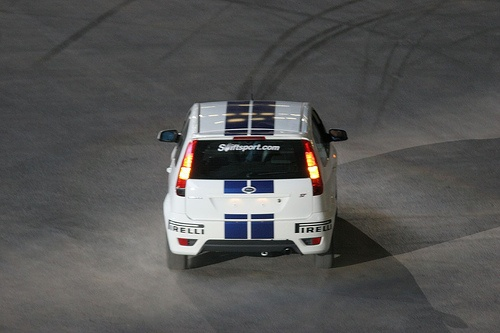

[[ 69.888    65.24925 157.248   181.62163]]
[6]


In [9]:
#Annotations를 통해 실제 Ground Truth Box를 추출하고,
#Input Size를 (224, 224, 3)으로 조정했으므로 Ground Truth Box도 (224, 224)에 맞추어 Resize
#generated_box_info = [x_min, y_min, x_max, y_max]와 추후에 Box의 Size를 구함

#하나의 이미지에 여러개의 Object가 있는 경우도 있고, 하나만 있는 경우가 있으므로
#Multi Class와 Single Class로 나눔

def get_labels_from_xml(xml_file_path, num_of_class = num_of_class):
    '''
    Input : 1 xml file
    Get class label, gt box coordinates.
    Because images are resized to 224x224, coordinates also need to be resized.
    Output: Existing class label, ground truth box coordinates
    '''
    f = open(xml_file_path)
    doc = xmltodict.parse(f.read()) 

    ori_img_height = float(doc['annotation']['size']['height'])
    ori_img_width  = float(doc['annotation']['size']['width'])

    class_label = [] 
    bbox_label  = [] 

    # multi-objects in image
    try:
        for each_obj in doc['annotation']['object']:
            obj_class = each_obj['name'].lower() 
            # Get bounding box coordinates
            x_min = float(each_obj['bndbox']['xmin']) # top left x-axis coordinate.
            x_max = float(each_obj['bndbox']['xmax']) # bottom right x-axis coordinate.
            y_min = float(each_obj['bndbox']['ymin']) # top left y-axis coordinate.
            y_max = float(each_obj['bndbox']['ymax']) # bottom right y-axis coordinate.

            # Images resized to 224x224. So resize the coordinates
            x_min = float((image_width/ori_img_width)*x_min)
            y_min = float((image_height/ori_img_height)*y_min)
            x_max = float((image_width/ori_img_width)*x_max)
            y_max = float((image_height/ori_img_height)*y_max)

            generated_box_info = [x_min, y_min, x_max, y_max]       # [top-left, bottom-right]

            index = classes.index(obj_class) 

            class_label.append(index)
            bbox_label.append(np.asarray(generated_box_info, dtype='float32'))

    # single-object in image
    except TypeError as e : 

        obj_class = doc['annotation']['object']['name']
        x_min = float(doc['annotation']['object']['bndbox']['xmin']) 
        x_max = float(doc['annotation']['object']['bndbox']['xmax']) 
        y_min = float(doc['annotation']['object']['bndbox']['ymin']) 
        y_max = float(doc['annotation']['object']['bndbox']['ymax']) 

        x_min = float((image_width/ori_img_width)*x_min)
        y_min = float((image_height/ori_img_height)*y_min)
        x_max = float((image_width/ori_img_width)*x_max)
        y_max = float((image_height/ori_img_height)*y_max)

        generated_box_info = [x_min, y_min, x_max, y_max]
        index = classes.index(obj_class) 

        class_label.append(index)
        bbox_label.append(np.asarray(generated_box_info, dtype='float32'))

    return class_label, np.asarray(bbox_label)
xml_file_path=list_annotations[3]
im = cv2.imread(list_images[3])
cv2_imshow(im)

class_label, bbox_label = get_labels_from_xml(xml_file_path, num_of_class = num_of_class)
print(bbox_label)
print(class_label)


##Examples for resized Ground Truth Box & Anchor Box

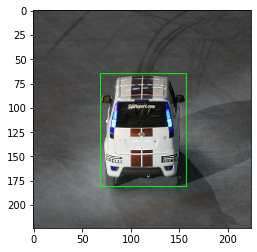

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
img_clone = np.copy(im)
img = cv2.resize(img_clone, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

for i in range(len(bbox_label)):
    cv2.rectangle(img, (bbox_label[i][0], bbox_label[i][1]), 
                              (bbox_label[i][2], bbox_label[i][3]),
                 color=(0, 255, 0), thickness=1)
    
plt.imshow(img)
plt.show()

In [12]:
#Subsample ratio로 resized된 이미지를 나누어서, 중심이되는 픽셀을 저장
feature_size = image_height/subsampled_ratio
ctr_x = np.arange(8, (feature_size + 1) * subsampled_ratio, subsampled_ratio)
ctr_y = np.arange(8, (feature_size + 1) * subsampled_ratio, subsampled_ratio)
print(len(ctr_x))
print(ctr_x)

28
[  8.  16.  24.  32.  40.  48.  56.  64.  72.  80.  88.  96. 104. 112.
 120. 128. 136. 144. 152. 160. 168. 176. 184. 192. 200. 208. 216. 224.]


In [13]:
index = 0
ctr = np.zeros((28*28, 2))

for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[i] - 4
        ctr[index, 0] = ctr_y[j] - 4
        index += 1
# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr[:10, :])

(784, 2)
[[ 4.  4.]
 [12.  4.]
 [20.  4.]
 [28.  4.]
 [36.  4.]
 [44.  4.]
 [52.  4.]
 [60.  4.]
 [68.  4.]
 [76.  4.]]


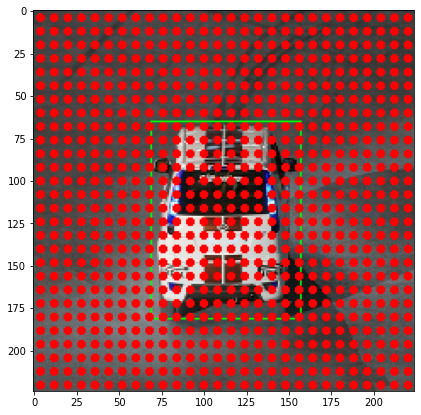

In [12]:
# display the 784 anchors within image
# Anchor Box가 만들어질 784개의 점을 Display
# 이후에 각 점당 9개씩 Anchor Box를 만들어냄

img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=2)
plt.imshow(img_clone2)
plt.show()

In [27]:
#설정한 ratio와 scale에 따라 9개의 anchor box를 만들어내는 과정
ratios = [0.5, 1, 2]
scales = [4, 8, 16]
sub_sample = 8

anchor_boxes = np.zeros(((28 * 28 * 9), 4))
index = 0

for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # anchor box [x1, y1, x2, y2]
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(7056, 4)
[[-18.627417    -7.3137085   26.627417    15.3137085 ]
 [-41.254834   -18.627417    49.254834    26.627417  ]
 [-86.50966799 -41.254834    94.50966799  49.254834  ]
 [-12.         -12.          20.          20.        ]
 [-28.         -28.          36.          36.        ]
 [-60.         -60.          68.          68.        ]
 [ -7.3137085  -18.627417    15.3137085   26.627417  ]
 [-18.627417   -41.254834    26.627417    49.254834  ]
 [-41.254834   -86.50966799  49.254834    94.50966799]
 [-18.627417     0.6862915   26.627417    23.3137085 ]]


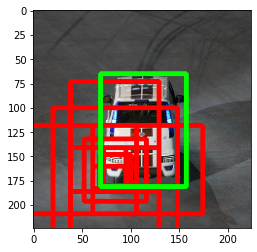

In [28]:
# draw random anchor boxes
img_clone = np.copy(img)
for i in range(2701, 2710):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox_label)):
    cv2.rectangle(img_clone, (bbox_label[i][0], bbox_label[i][1]), 
                             (bbox_label[i][2], bbox_label[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()



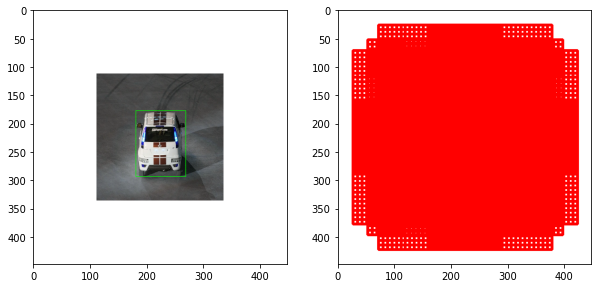

array([[-18.627417  ,  -7.3137085 ,  26.627417  ,  15.3137085 ],
       [-41.254834  , -18.627417  ,  49.254834  ,  26.627417  ],
       [-86.50966799, -41.254834  ,  94.50966799,  49.254834  ],
       ...,
       [208.6862915 , 197.372583  , 231.3137085 , 242.627417  ],
       [197.372583  , 174.745166  , 242.627417  , 265.254834  ],
       [174.745166  , 129.49033201, 265.254834  , 310.50966799]])

In [29]:
# draw all anchor boxes

# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,112,112,112,112,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+112, y1+112), (x2+112, y2+112), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()
anchor_boxes

In [32]:
# only 3160 anchor boxes are inside the boundary out of 6804
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 224) &
        (anchor_boxes[:, 3] <= 224))[0]

print(index_inside.shape)
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)
valid_anchor_boxes

(3160,)
(3160, 4)


array([[  0.6862915,   5.372583 ,  23.3137085,  50.627417 ],
       [  0.6862915,  13.372583 ,  23.3137085,  58.627417 ],
       [  0.6862915,  21.372583 ,  23.3137085,  66.627417 ],
       ...,
       [200.6862915, 157.372583 , 223.3137085, 202.627417 ],
       [200.6862915, 165.372583 , 223.3137085, 210.627417 ],
       [200.6862915, 173.372583 , 223.3137085, 218.627417 ]])

##Calculate IoU

In [33]:
ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox_label):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[1500:1501, :])

(3160, 4)
[[0.42411464 0.         0.         0.        ]]


In [34]:
# what anchor box has max ou with the ground truth box

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1348    0    0    0]
[0.62050116 0.         0.         0.        ]
[   0    0    0 ... 3159 3159 3159]


In [35]:
# what ground truth bbox is associated with each anchor box

argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(3160,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [36]:
label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(3160,)


In [37]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [95]:
# convert the format of valid anchor boxes [x1, y1, x2, y2]
# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox_label[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)
anchor_locs

(3160, 4)
(3160, 4)


array([[163.98070408,   2.10884521,   4.84649033,   0.94448569],
       [163.98070408,   1.93206852,   4.84649033,   0.94448569],
       [163.98070408,   1.75529182,   4.84649033,   0.94448569],
       ...,
       [ -0.93410185,  -1.249912  ,  -0.83170543,   0.94448569],
       [ -0.93410185,  -1.42668869,  -0.83170543,   0.94448569],
       [ -0.93410185,  -1.60346539,  -0.83170543,   0.94448569]])

In [40]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - 128),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [81]:
# First set the label=-1 and locations=0 of the 7056 anchor boxes, 
# and then fill in the locations and labels of the 7056 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 7056 valid anchor boxes, and the others are marked with -1

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[0:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:5000, :])

(7056,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(7056, 4)
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 ...
 [ 0.          0.          0.          0.        ]
 [-0.68879999 -2.0176425  -0.4716049   1.29105928]
 [-0.58412903 -1.00882125 -0.35024405  0.5979121 ]]


##Classification & Bounding Box Regression

In [75]:
from keras import layers
from keras import models
input_shape=layers.Input(shape=(224,224,3))
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(input_shape)
x = layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x)
x = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
feature_extractor = layers.Conv2D(filters=512, kernel_size=(3,3), padding="valid", activation="relu")(x)
obj_conv = layers.Conv2D(filters=18, kernel_size=(1,1), padding="valid", activation=None)(feature_extractor)
#Classification layer
bb_conv = layers.Conv2D(filters=36, kernel_size=(1,1), padding="valid", activation=None)(feature_extractor)
#bbox Regression layer

<KerasTensor: shape=(None, 26, 26, 18) dtype=float32 (created by layer 'conv2d_63')>

##Loss Function(Classification loss & Bounding box regression loss)

In [72]:
import tensorflow.keras.backend as K
def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typically: [N, 4], but could be any shape.
    """
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss

Y_obj   = layers.Input(shape=(26*26*9,2))
Y_coor  = layers.Input(shape=(26*26*9,4))
anch_bool = layers.Input(shape=(26*26*9))

class_conv_reshape = tf.reshape(obj_conv, (-1, 26*26*9, 2)) #6084*2
anchor_conv_reshape = tf.reshape(bb_conv, (-1, 26*26*9, 4)) #6084*4

learning_rate = 1e-5
decay_steps = 10000
decay_rate = 0.99
lambda_value= 10
logits = tf.nn.softmax(class_conv_reshape)
decayed_1r = tf.keras.optimizers.schedules.ExponentialDecay(
  learning_rate, decay_steps, decay_rate, staircase=False, name=None)

loss1 = 1/256*tf.reduce_sum(anch_bool*(tf.nn.softmax_cross_entropy_with_logits(labels=Y_obj, logits=class_conv_reshape)))
# positive(128) + negative(128)
# (10, 6084, 2)

loss2 = lambda_value*(1/128)*tf.reduce_sum((tf.reshape(Y_obj[:,:,0], (-1,26*26*9,1)))*smooth_l1_loss(anchor_conv_reshape, Y_coor))
total_loss = loss1 + loss2

In [73]:
# Send the 6804 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 6804 ROI to 1500
n_test_pre_nms = 3000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [94]:
# the labelled 7056 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(7056,)


array([ 22.627417  ,  45.254834  ,  90.50966799, ...,  45.254834  ,
        90.50966799, 181.01933598])

In [101]:
#classifier에 anchor_labels
#Box regression에 anchor_locations
#이후에 RoI Pooling을 통해서 RPN완성
from keras.models import Model
model = models.Model(inputs = input_shape, outputs= x)
model_obj = models.Model(inputs = input_shape, outputs= obj_conv)
model_bb = models.Model(inputs = input_shape, outputs= bb_conv)

In [ ]:
def read_images(first_index, last_index):
    '''
    Read the image files, then resize.
    Input : first and last index.
    Output: numpy array of images.
    '''
    images_list = []
    
    for i in range(first_index, last_index):
        
        im = cv2.imread(list_images[i])
        im = cv2.resize(im, (image_height, image_width))
        
        images_list.append(im)
    
    return np.asarray(images_list)

train_data = read_images(1, 500